In [250]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
import os
import pandas as pd
import numpy as np
import warnings
import gc
import seaborn as sns
import matplotlib.pyplot as plt
import unicodedata
from statsmodels.stats.outliers_influence import variance_inflation_factor
warnings.filterwarnings('ignore')

In [251]:
# para ver la totalidad del archivo a leer
pd.set_option('display.max_columns', None)

In [252]:
df1 = pd.read_csv(r"C:\Users\Admin\Downloads\Colsubsidio\Prueba_Científico\train.csv", encoding="latin1", sep=";")
df2 = pd.read_excel(r"C:\Users\Admin\Downloads\Colsubsidio\Prueba_Científico\train_test_demograficas.xlsx")
df3 = pd.read_excel(r"C:\Users\Admin\Downloads\Colsubsidio\Prueba_Científico\train_test_subsidios.xlsx")

In [253]:
df4=df1.merge(df2, on='id', how='inner').merge(df3, on='id', how='inner')
print(df4.shape)
del df1, df2, df3
gc.collect()

(50001, 34)


55134

In [254]:
# Asegurar que ambas columnas estén en formato datetime
df4['Fecha.Proceso'] = pd.to_datetime(df4['Fecha.Proceso'], format="%d/%m/%Y", errors="coerce")
df4['Fecha.Expedicion'] = pd.to_datetime(df4['Fecha.Expedicion'], format="%d/%m/%Y", errors="coerce")

In [255]:
def limpiar_texto(texto):
    if pd.isna(texto):
        return texto
    # pasar a minúsculas
    texto = texto.lower().strip()
    # quitar acentos/tildes
    texto = ''.join(
        c for c in unicodedata.normalize('NFKD', texto)
        if not unicodedata.combining(c)
    )
    return texto

df4['nivel_educativo'] = df4['nivel_educativo'].apply(limpiar_texto)
df4['estado_civil'] = df4['estado_civil'].apply(limpiar_texto)

In [256]:
# Lista de columnas a convertir a entero
cols_int = ["cuota_monetaria", "sub_vivenda", "bono_lonchera", "PAC", "contrato", "edad"]

for col in cols_int:
    df4[col] = (
        df4[col]
        .astype(str)                               # convertir a string
        .str.replace(r"[^0-9-]", "", regex=True)   # quitar todo lo que no sea número o signo negativo
        .replace("", "0")                          # si queda vacío, poner 0
        .astype(int)                               # convertir a entero
    )

In [257]:
# Lista de columnas a convertir
cols_convertir = [
    "Disponible.Avances",
    "Limite.Avances",
    "Total.Intereses",
    "Saldos.Mes.Ant",
    "Pagos.Mes.Ant",
    "Vtas.Mes.Ant",
    "Limite.Cupo",
    "Pago.del.Mes",
    "Pago.Minimo",
    "Vr.Mora",
    "Vr.Cuota.Manejo",
    "Saldo"
]

# Limpiar y convertir a float
for col in cols_convertir:
    df4[col] = (
        df4[col]
        .astype(str)                       # aseguramos string
        .str.replace(r"[^0-9\-,.]", "", regex=True)  # quitar símbolos raros
        .str.replace(",", ".", regex=False)          # estandarizar decimales
        .astype(float)                     # convertir a float
    )

In [258]:
df4['segmento'] = df4['segmento'].str.split('_', n=1).str[-1]

In [259]:
#Validación % Nulos
percent_missing = df4.isnull().sum() * 100 / len(df4)
missing_value_df = pd.DataFrame({'Variables': df4.columns,
                                 'PorcentajeNulos': percent_missing})
#Identificar columnas con porcentaje de missing altos
columnas_missing = missing_value_df[(missing_value_df['PorcentajeNulos'] >=10)].copy() # original 50
columnas_missing.sort_values(["PorcentajeNulos"], ascending = (False))
columnas_missing

,Variables,PorcentajeNulos
Cancelacion,Cancelacion,97.176056
Gestionable,Gestionable,97.176056
Retencion,Retencion,97.176056
TIPO,TIPO,97.176056
ANO_MES,ANO_MES,97.176056
estrato,estrato,91.768165


In [260]:
#Eliminación de columnas con porcentaje de missing altos
lista_columnas = columnas_missing['Variables'].tolist()
df4 = df4.drop(lista_columnas, axis=1)

In [261]:
df4.segmento.value_counts()

segmento
Basico    23304
Medio     22377
Joven      3286
Alto       1034
Name: count, dtype: int64

In [262]:
## Dumizar variables categóricas
df_dummies = pd.get_dummies(
    df4[['segmento', 'nivel_educativo', 'estado_civil', 'Genero','categoria']],
    prefix=['segmento', 'nivel_educativo', 'estado_civil', 'Genero','categoria']
)

# Unir al df4 original (opcional)
df4 = pd.concat([df4.drop(columns=['segmento','nivel_educativo','estado_civil','Genero','categoria']), df_dummies], axis=1)

In [263]:
df4.drop(columns=['Fecha.Expedicion','Fecha.Proceso'], inplace=True)

In [264]:
df4 = df4.set_index('id')

In [265]:
bool_cols = df4.select_dtypes(include='bool').columns
df4[bool_cols] = df4[bool_cols].astype(int)

In [266]:
df4

,Target,Disponible.Avances,Limite.Avances,Total.Intereses,Saldos.Mes.Ant,Pagos.Mes.Ant,Vtas.Mes.Ant,Edad.Mora,Limite.Cupo,Pago.del.Mes,Pago.Minimo,Vr.Mora,Vr.Cuota.Manejo,Saldo,edad,PAC,contrato,cuota_monetaria,sub_vivenda,bono_lonchera,segmento_Alto,segmento_Basico,segmento_Joven,segmento_Medio,nivel_educativo_posgrado,nivel_educativo_primaria,nivel_educativo_secundaria,nivel_educativo_tecnico_tecnologico,estado_civil_casado,estado_civil_separado,estado_civil_soltero,estado_civil_viudo,Genero_F,Genero_M,categoria_A,categoria_B,categoria_C
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,1050000.0,1050000.0,0.0,0.0,0.0,0.0,0,2625000.0,0.0,0.0,0.0,0.0,0.0,31,1,4,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0
2,0,1180000.0,1180000.0,0.0,0.0,0.0,0.0,0,2950000.0,0.0,0.0,0.0,0.0,0.0,38,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1
3,0,150000.0,150000.0,0.0,0.0,0.0,0.0,0,500000.0,0.0,0.0,0.0,0.0,0.0,42,3,3,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0
4,0,680000.0,680000.0,0.0,0.0,0.0,0.0,0,1700000.0,0.0,0.0,0.0,0.0,0.0,60,1,4,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0
5,0,3307500.0,3307500.0,0.0,0.0,0.0,0.0,0,6615000.0,0.0,0.0,0.0,0.0,0.0,27,1,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49997,0,55000.0,55000.0,0.0,0.0,0.0,0.0,0,550000.0,0.0,0.0,0.0,0.0,0.0,29,3,3,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0
49998,0,80000.0,80000.0,0.0,0.0,0.0,0.0,0,800000.0,0.0,0.0,0.0,0.0,0.0,48,2,2,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0
49999,0,80000.0,80000.0,0.0,0.0,0.0,0.0,0,800000.0,0.0,0.0,0.0,0.0,0.0,55,2,2,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0


In [267]:
bool_cols

Index(['segmento_Alto', 'segmento_Basico', 'segmento_Joven', 'segmento_Medio',
       'nivel_educativo_posgrado', 'nivel_educativo_primaria',
       'nivel_educativo_secundaria', 'nivel_educativo_tecnico_tecnologico',
       'estado_civil_casado', 'estado_civil_separado', 'estado_civil_soltero',
       'estado_civil_viudo', 'Genero_F', 'Genero_M', 'categoria_A',
       'categoria_B', 'categoria_C'],
      dtype='object')

In [268]:
# Umbral mínimo
threshold = 0.02

# Columnas candidatas: las que solo tienen 2 valores distintos (0 y 1 por ejemplo)
binary_cols = [col for col in df4.columns if df4[col].nunique(dropna=True) == 2]

# Identificar columnas poco informativas
cols_to_drop = []
for col in binary_cols:
    freqs = df4[col].value_counts(normalize=True)
    if freqs.min() <= threshold:
        cols_to_drop.append(col)

# Eliminar esas columnas
df4 = df4.drop(columns=cols_to_drop)

print("Columnas eliminadas:", cols_to_drop)


Columnas eliminadas: ['sub_vivenda', 'nivel_educativo_posgrado']


In [269]:
df4.describe()

,Target,Disponible.Avances,Limite.Avances,Total.Intereses,Saldos.Mes.Ant,Pagos.Mes.Ant,Vtas.Mes.Ant,Edad.Mora,Limite.Cupo,Pago.del.Mes,Pago.Minimo,Vr.Mora,Vr.Cuota.Manejo,Saldo,edad,PAC,contrato,cuota_monetaria,bono_lonchera,segmento_Alto,segmento_Basico,segmento_Joven,segmento_Medio,nivel_educativo_primaria,nivel_educativo_secundaria,nivel_educativo_tecnico_tecnologico,estado_civil_casado,estado_civil_separado,estado_civil_soltero,estado_civil_viudo,Genero_F,Genero_M,categoria_A,categoria_B,categoria_C
count,50001.000000,5.000100e+04,5.000100e+04,5.000100e+04,5.000100e+04,5.000100e+04,5.000100e+04,50001.000000,5.000100e+04,5.000100e+04,5.000100e+04,5.000100e+04,50001.000000,5.000100e+04,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000
mean,0.028239,3.809796e+05,4.763577e+05,2.663729e+04,3.416084e+05,3.998243e+04,2.695985e+04,90.322794,1.265604e+06,1.324304e+04,1.267745e+05,3.312106e+04,13837.300871,3.408783e+05,41.454711,2.158717,2.492010,0.750785,0.631667,0.020680,0.466071,0.065719,0.447531,0.527249,0.104418,0.368133,0.182616,0.184136,0.443591,0.189656,0.497490,0.502510,0.548209,0.345113,0.106678
std,0.165658,7.074502e+05,7.324546e+05,1.140605e+05,7.169439e+05,1.961892e+05,1.819486e+05,410.590224,6.481920e+06,1.319769e+05,4.180144e+05,1.801410e+05,38806.376239,7.137114e+05,13.868883,0.933278,1.114604,0.432563,0.482357,0.142311,0.498852,0.247792,0.497244,0.499262,0.305805,0.482302,0.386356,0.387599,0.496813,0.392033,0.499999,0.499999,0.497675,0.475410,0.308706
min,0.000000,0.000000e+00,4.500000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.500000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,18.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,6.792900e+04,1.500000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,5.000000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,30.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.650000e+05,2.250000e+05,0.000000e+00,8.000000e-01,0.000000e+00,0.000000e+00,0.000000,7.500000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,6.600000e-01,41.000000,3.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
75%,0.000000,3.893920e+05,5.120000e+05,8.052760e+03,5.017244e+05,4.948000e+03,0.000000e+00,0.000000,1.288000e+06,0.000000e+00,5.387300e+04,0.000000e+00,4947.000000,4.977085e+05,53.000000,3.000000,3.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.650000e+07,1.650000e+07,4.529165e+06,1.892768e+07,1.387500e+07,1.387508e+07,4050.000000,1.400000e+09,1.062928e+07,1.892768e+07,9.928620e+06,316061.000000,1.893768e+07,65.000000,3.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [270]:
len(df4[df4['Edad.Mora'] > 90])/len(df4)

0.06797864042719146

In [271]:
## selecionamos las edades de mora menor a 90 dias
df4=df4[df4['Edad.Mora'] <= 90]

In [272]:
def winsorize_series(s, lower_q=0.01, upper_q=0.99, code_map=None):
    if code_map:
        s = s.replace(code_map)
    lower, upper = s.quantile(lower_q), s.quantile(upper_q)
    return s.clip(lower=lower, upper=upper)

In [273]:
# Columnas a procesar
cols = [
    "Disponible.Avances",
    "Limite.Avances",
    "Total.Intereses",
    "Saldos.Mes.Ant",
    "Pagos.Mes.Ant",
    "Vtas.Mes.Ant",
    "Edad.Mora",
    "Limite.Cupo",
    "Pago.del.Mes",
    "Pago.Minimo",
    "Vr.Mora",
    "Vr.Cuota.Manejo",
    "Saldo"
    ]

# Si las columnas usan 98/99 como “sin dato”:
code_map = {98: np.nan, 99: np.nan}

for col in cols:
    df4[col] = winsorize_series(df4[col], code_map=code_map)

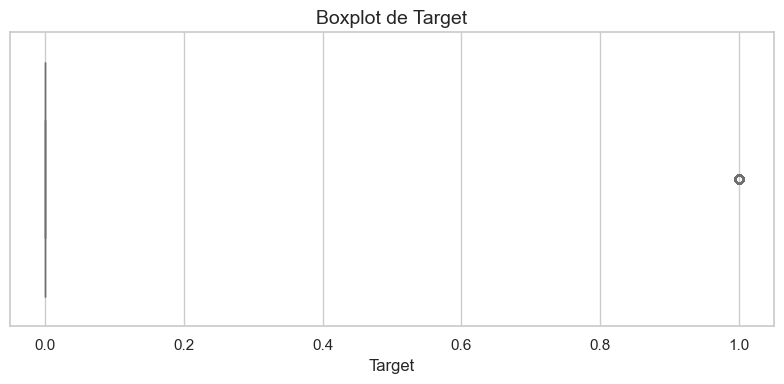

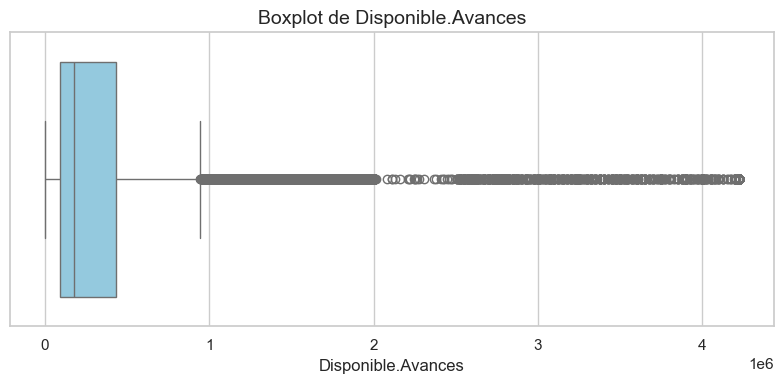

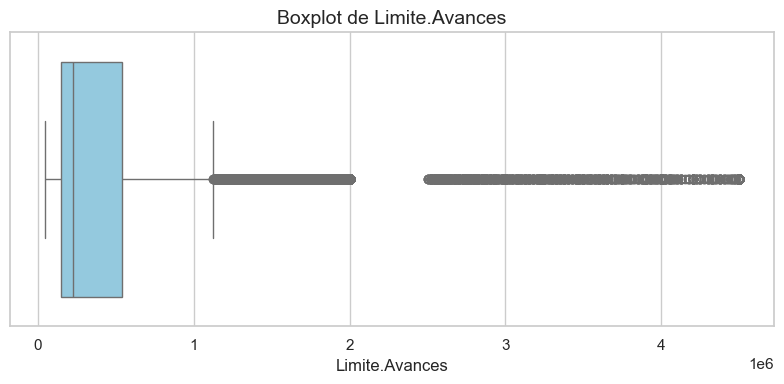

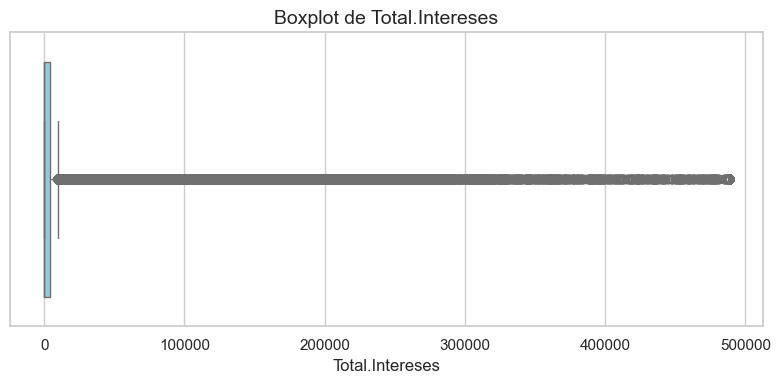

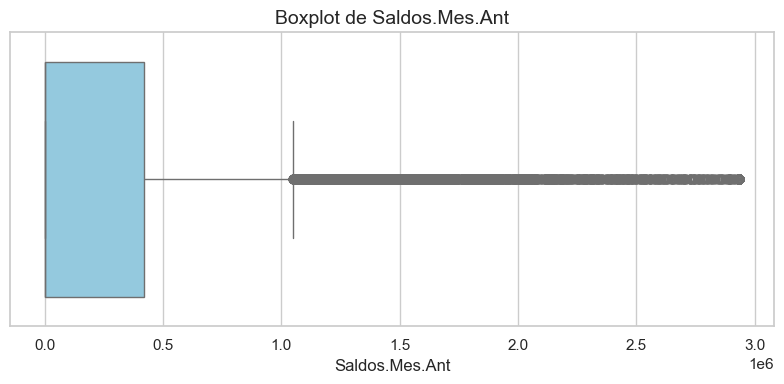

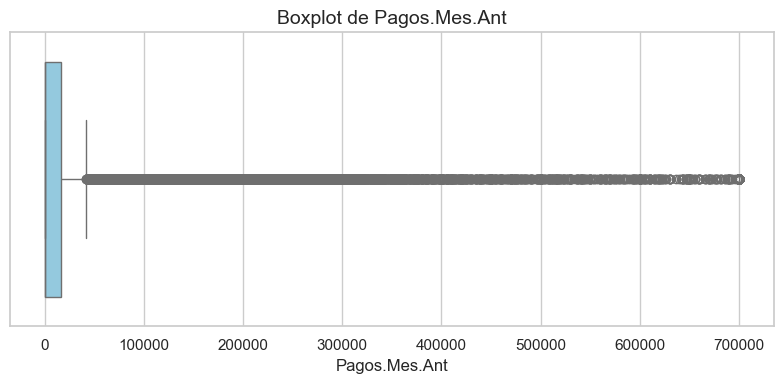

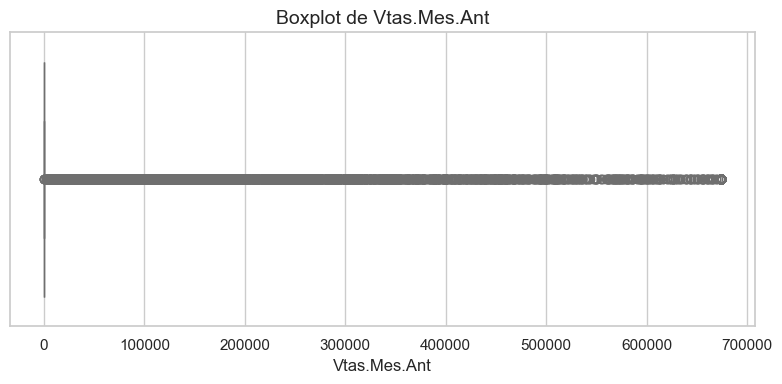

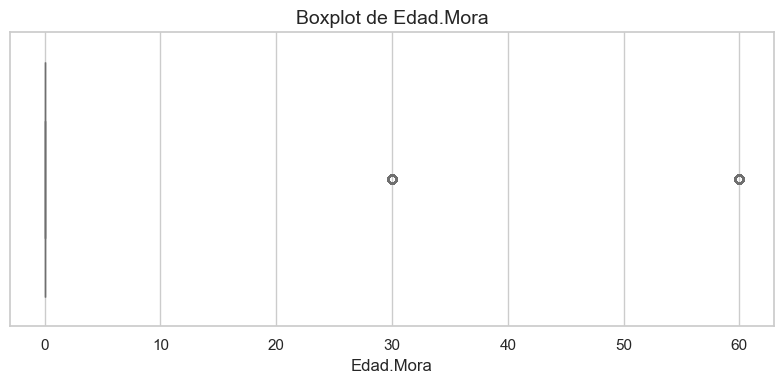

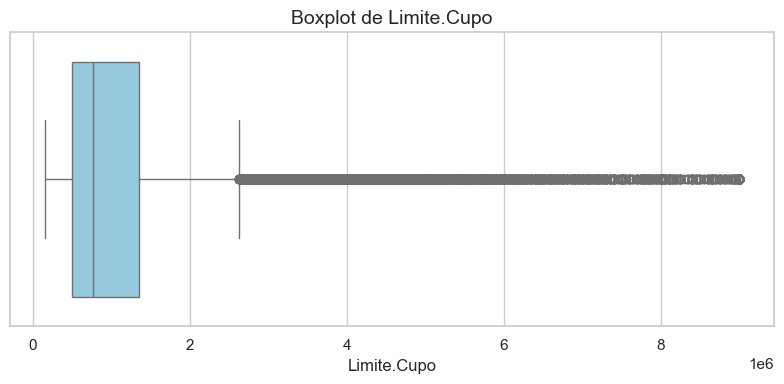

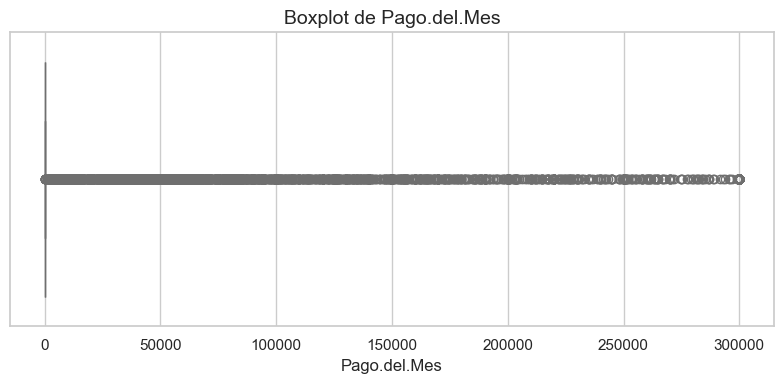

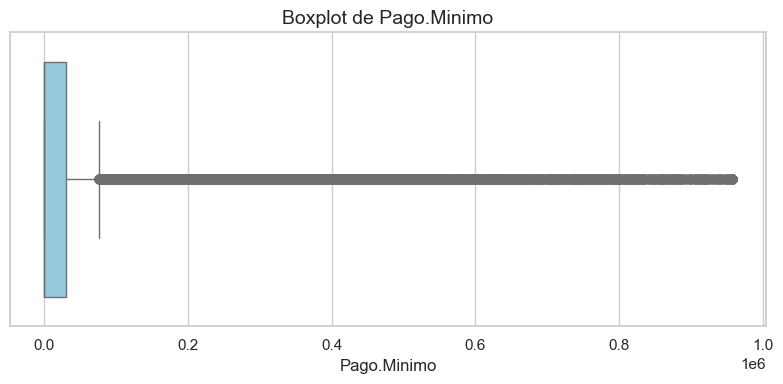

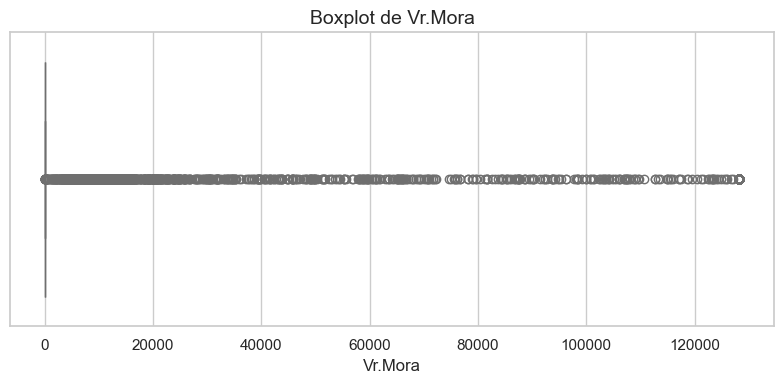

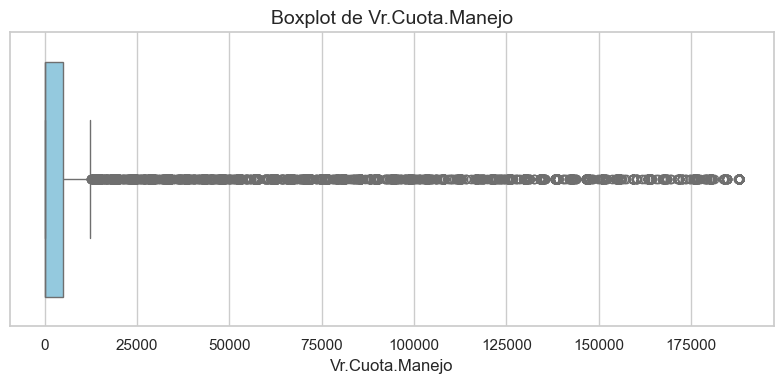

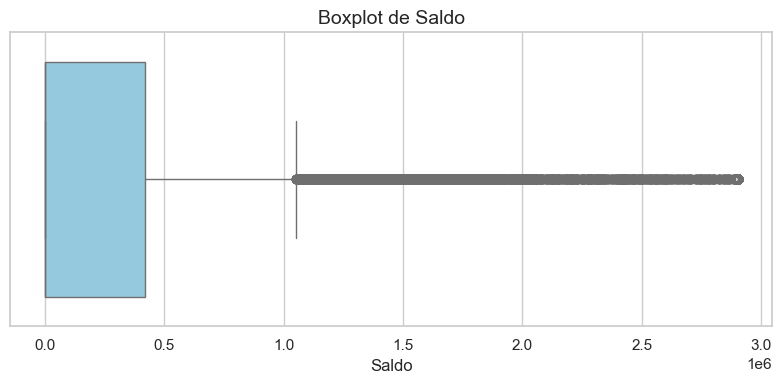

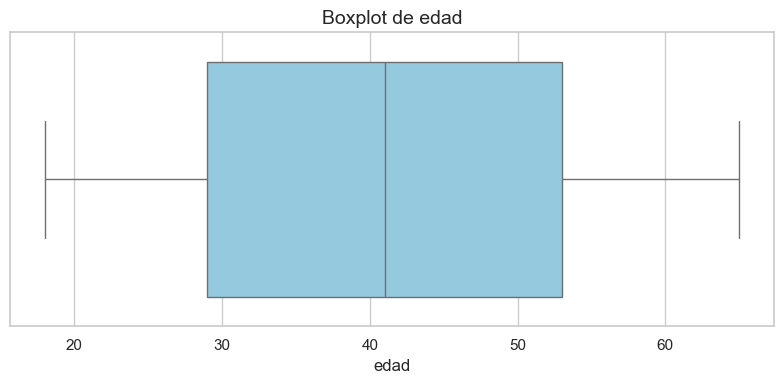

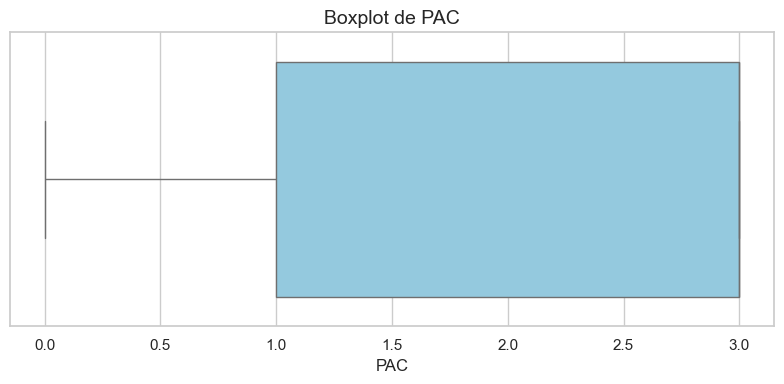

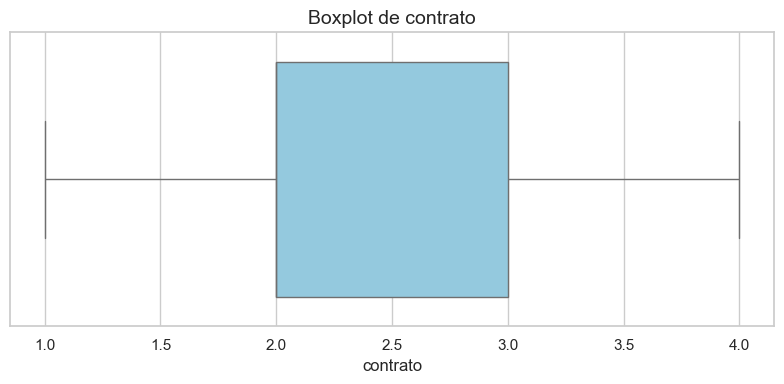

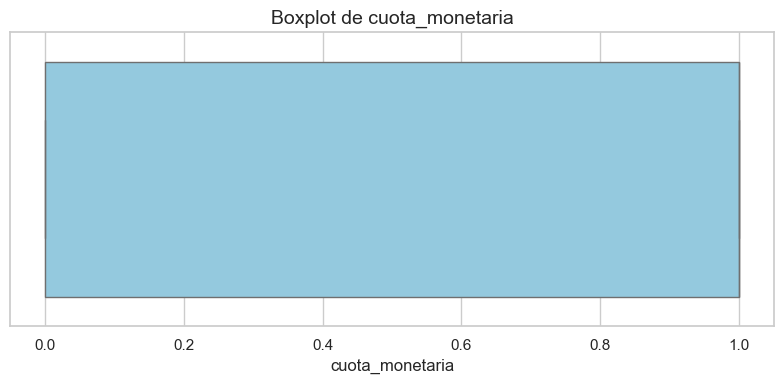

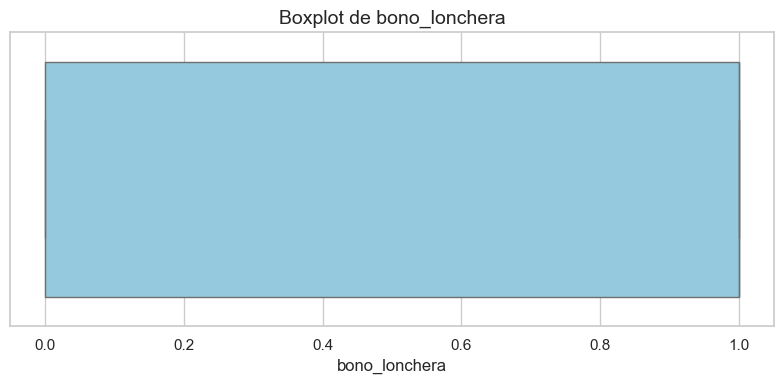

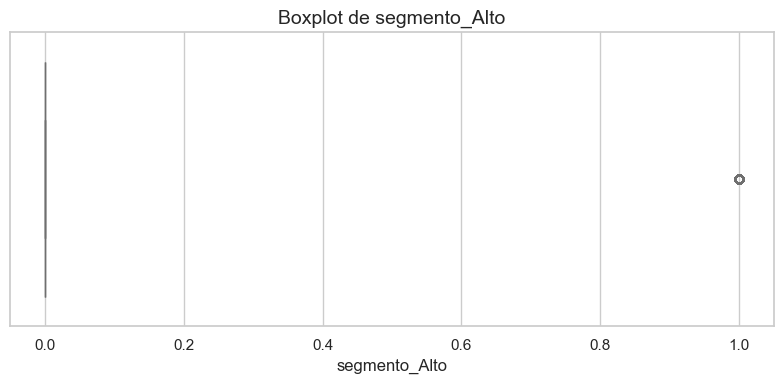

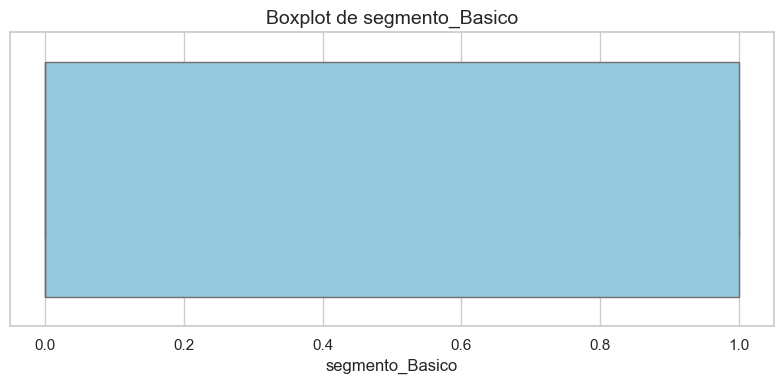

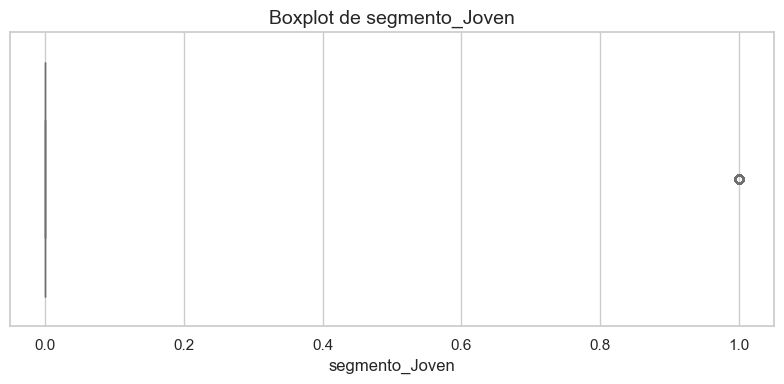

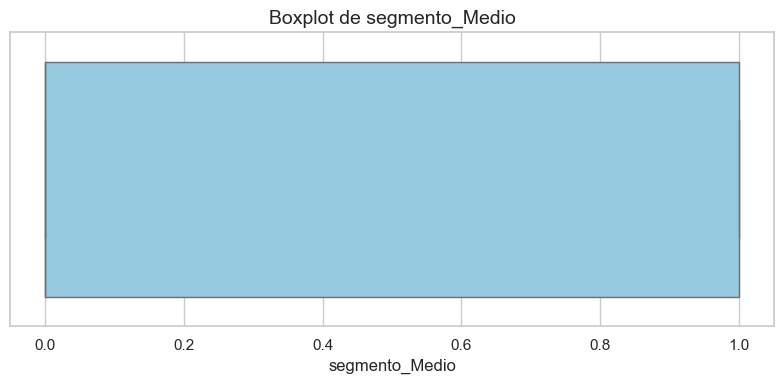

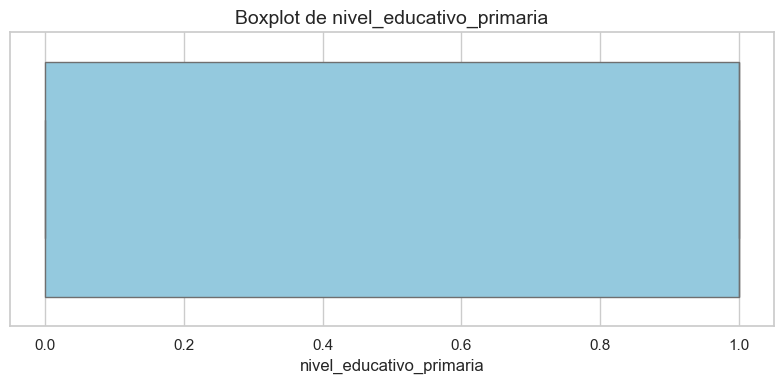

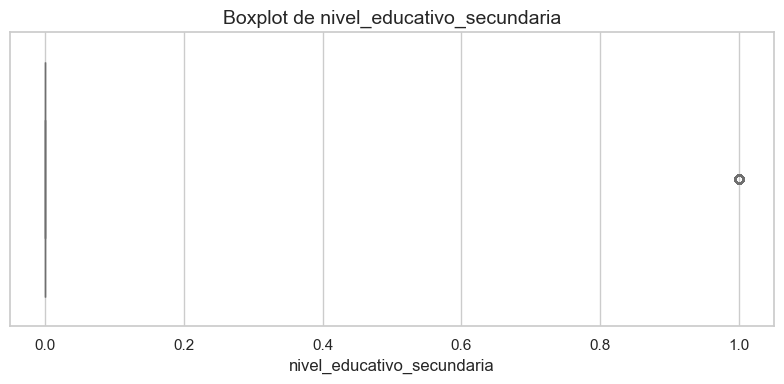

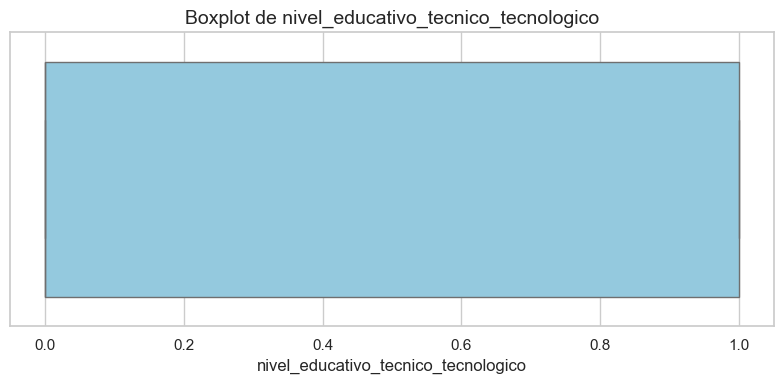

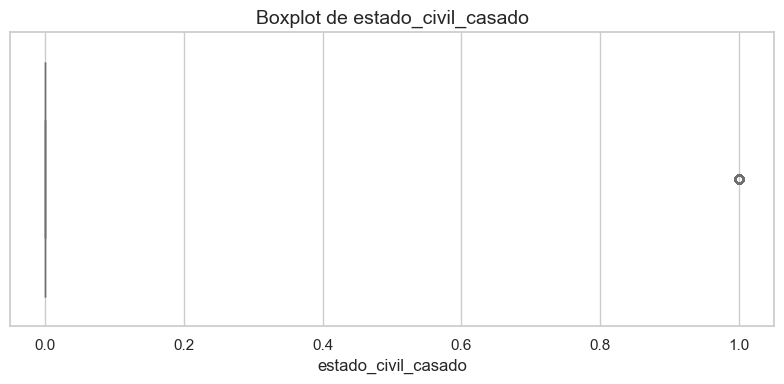

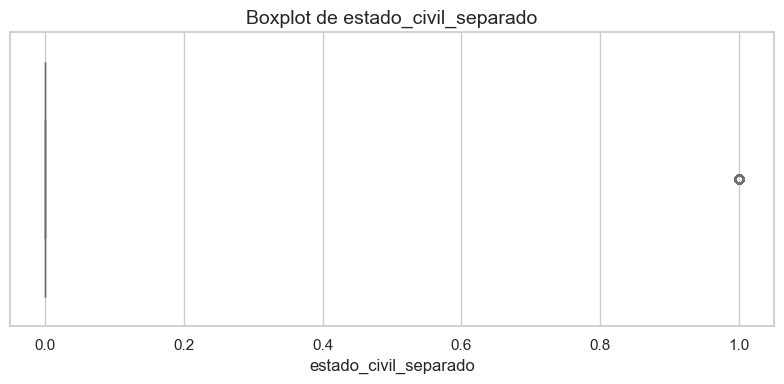

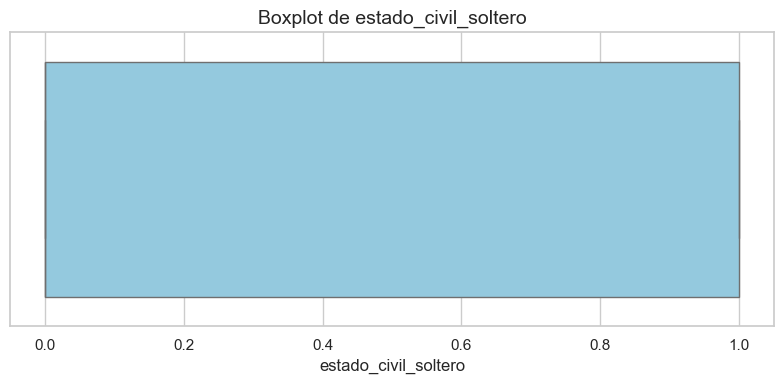

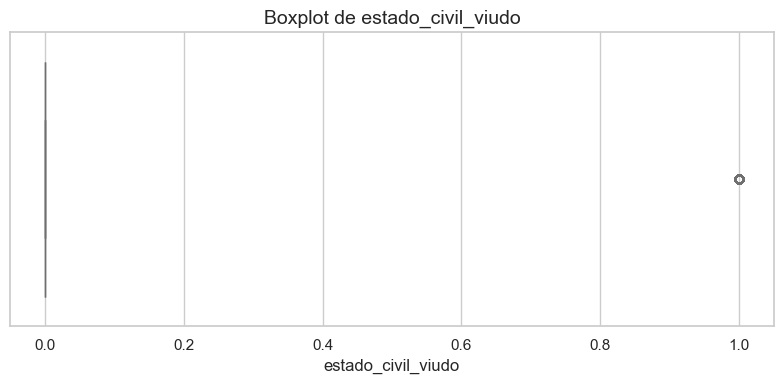

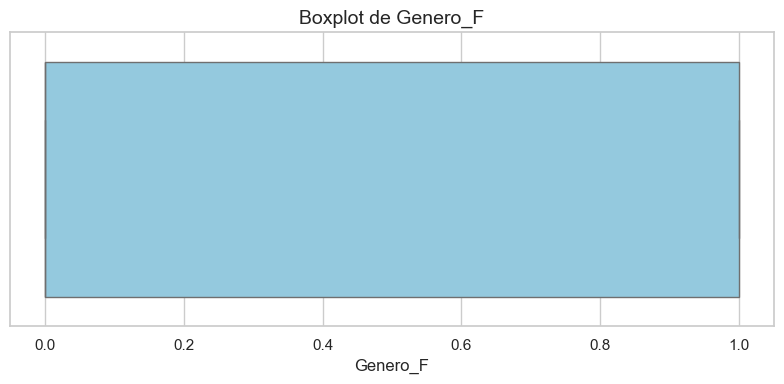

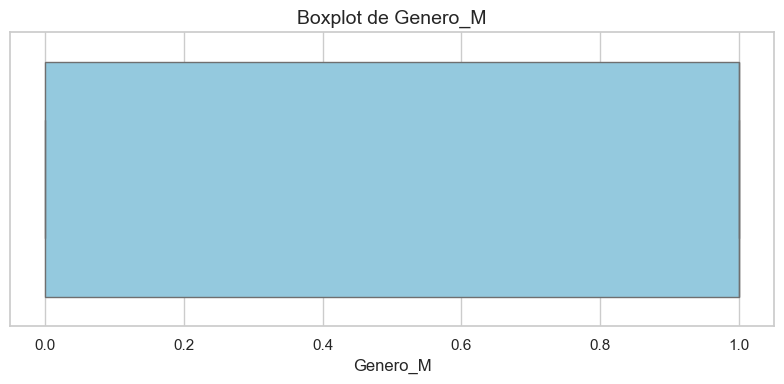

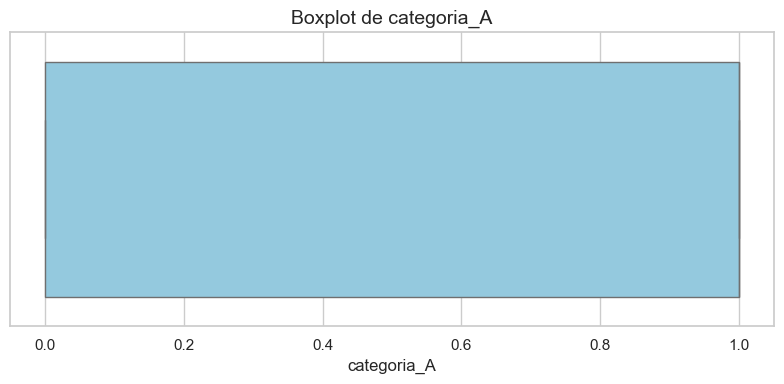

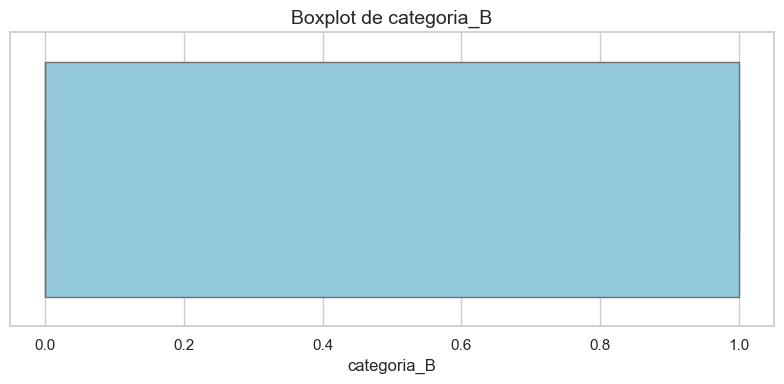

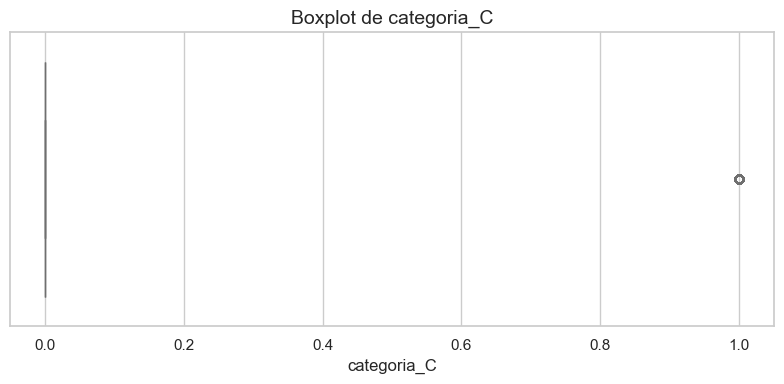

In [274]:
# Seleccionar las columnas numéricas
numeric_cols = df4.select_dtypes(include=["int64","float64"]).columns.tolist()

# Convertir a un DataFrame de Pandas
df_pandas = df4[numeric_cols]

# Configuración general del estilo
sns.set(style="whitegrid")
plt.rcParams.update({'figure.max_open_warning': 0})  # Evitar advertencias por muchas gráficas

# Iterar sobre cada columna y generar un boxplot individual
for column in df_pandas.columns:
    plt.figure(figsize=(8, 4))  # Tamaño de la figura
    sns.boxplot(data=df_pandas, x=column, color="skyblue")
    
    # Título y etiquetas
    plt.title(f"Boxplot de {column}", fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.tight_layout()
    
    # Mostrar la gráfica
    plt.show()

In [275]:
df4

,Target,Disponible.Avances,Limite.Avances,Total.Intereses,Saldos.Mes.Ant,Pagos.Mes.Ant,Vtas.Mes.Ant,Edad.Mora,Limite.Cupo,Pago.del.Mes,Pago.Minimo,Vr.Mora,Vr.Cuota.Manejo,Saldo,edad,PAC,contrato,cuota_monetaria,bono_lonchera,segmento_Alto,segmento_Basico,segmento_Joven,segmento_Medio,nivel_educativo_primaria,nivel_educativo_secundaria,nivel_educativo_tecnico_tecnologico,estado_civil_casado,estado_civil_separado,estado_civil_soltero,estado_civil_viudo,Genero_F,Genero_M,categoria_A,categoria_B,categoria_C
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,1050000.0,1050000.0,0.0,0.0,0.0,0.0,0,2625000.0,0.0,0.0,0.0,0.0,0.0,31,1,4,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0
2,0,1180000.0,1180000.0,0.0,0.0,0.0,0.0,0,2950000.0,0.0,0.0,0.0,0.0,0.0,38,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1
3,0,150000.0,150000.0,0.0,0.0,0.0,0.0,0,500000.0,0.0,0.0,0.0,0.0,0.0,42,3,3,1,1,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0
4,0,680000.0,680000.0,0.0,0.0,0.0,0.0,0,1700000.0,0.0,0.0,0.0,0.0,0.0,60,1,4,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0
5,0,3307500.0,3307500.0,0.0,0.0,0.0,0.0,0,6615000.0,0.0,0.0,0.0,0.0,0.0,27,1,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49997,0,55000.0,55000.0,0.0,0.0,0.0,0.0,0,550000.0,0.0,0.0,0.0,0.0,0.0,29,3,3,1,1,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0
49998,0,80000.0,80000.0,0.0,0.0,0.0,0.0,0,800000.0,0.0,0.0,0.0,0.0,0.0,48,2,2,1,1,0,1,0,0,0,1,0,0,0,1,0,0,1,1,0,0
49999,0,80000.0,80000.0,0.0,0.0,0.0,0.0,0,800000.0,0.0,0.0,0.0,0.0,0.0,55,2,2,1,1,0,1,0,0,0,1,0,0,0,0,1,0,1,1,0,0


In [276]:
def correlacion_objetivo(df, variable_objetivo, top_n=10):
    """
    Muestra un gráfico de barras con las variables más correlacionadas con la variable objetivo.
    
    Parámetros:
    - df: DataFrame
    - variable_objetivo: str, nombre de la variable objetivo
    - top_n: int, cuántas variables mostrar (ordenadas por correlación)
    """
    # Calcular matriz de correlación
    corr = df.corr(numeric_only=True)

    if variable_objetivo not in corr.columns:
        raise ValueError(f"La variable '{variable_objetivo}' no está en el DataFrame numérico.")

    # Tomar solo correlación con la variable objetivo
    corrs = corr[variable_objetivo].drop(variable_objetivo)
    
    # Ordenar por correlación absoluta
    corrs_ordenadas = corrs.reindex(corrs.abs().sort_values(ascending=False).index)
    
    # Seleccionar top_n
    corrs_ordenadas = corrs_ordenadas.head(top_n)

    # Graficar
    plt.figure(figsize=(8, 6))
    corrs_ordenadas.plot(kind='barh', color='skyblue')
    plt.axvline(0, color='gray', linewidth=1)
    plt.title(f'Correlación con la variable objetivo: {variable_objetivo}')
    plt.xlabel('Correlación')
    plt.gca().invert_yaxis()  # Para que las más altas queden arriba
    plt.tight_layout()
    plt.show()

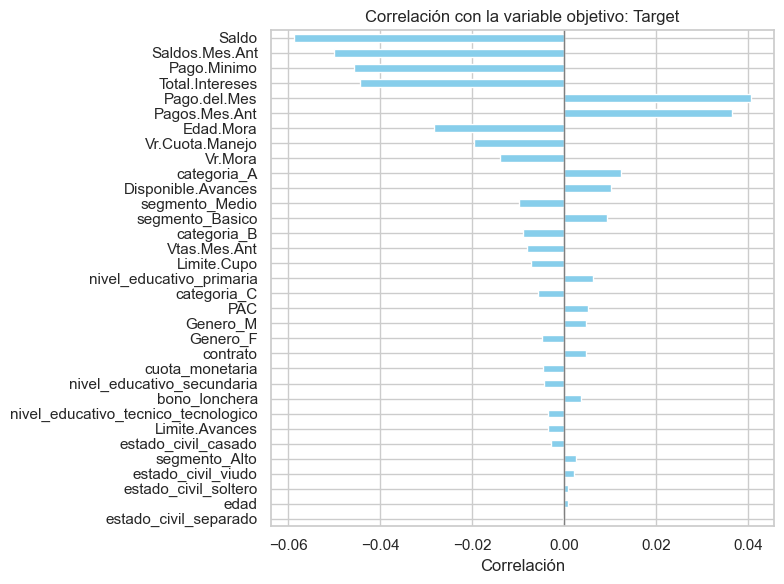

In [277]:
correlacion_objetivo(df4, variable_objetivo="Target", top_n=33)

<Axes: >

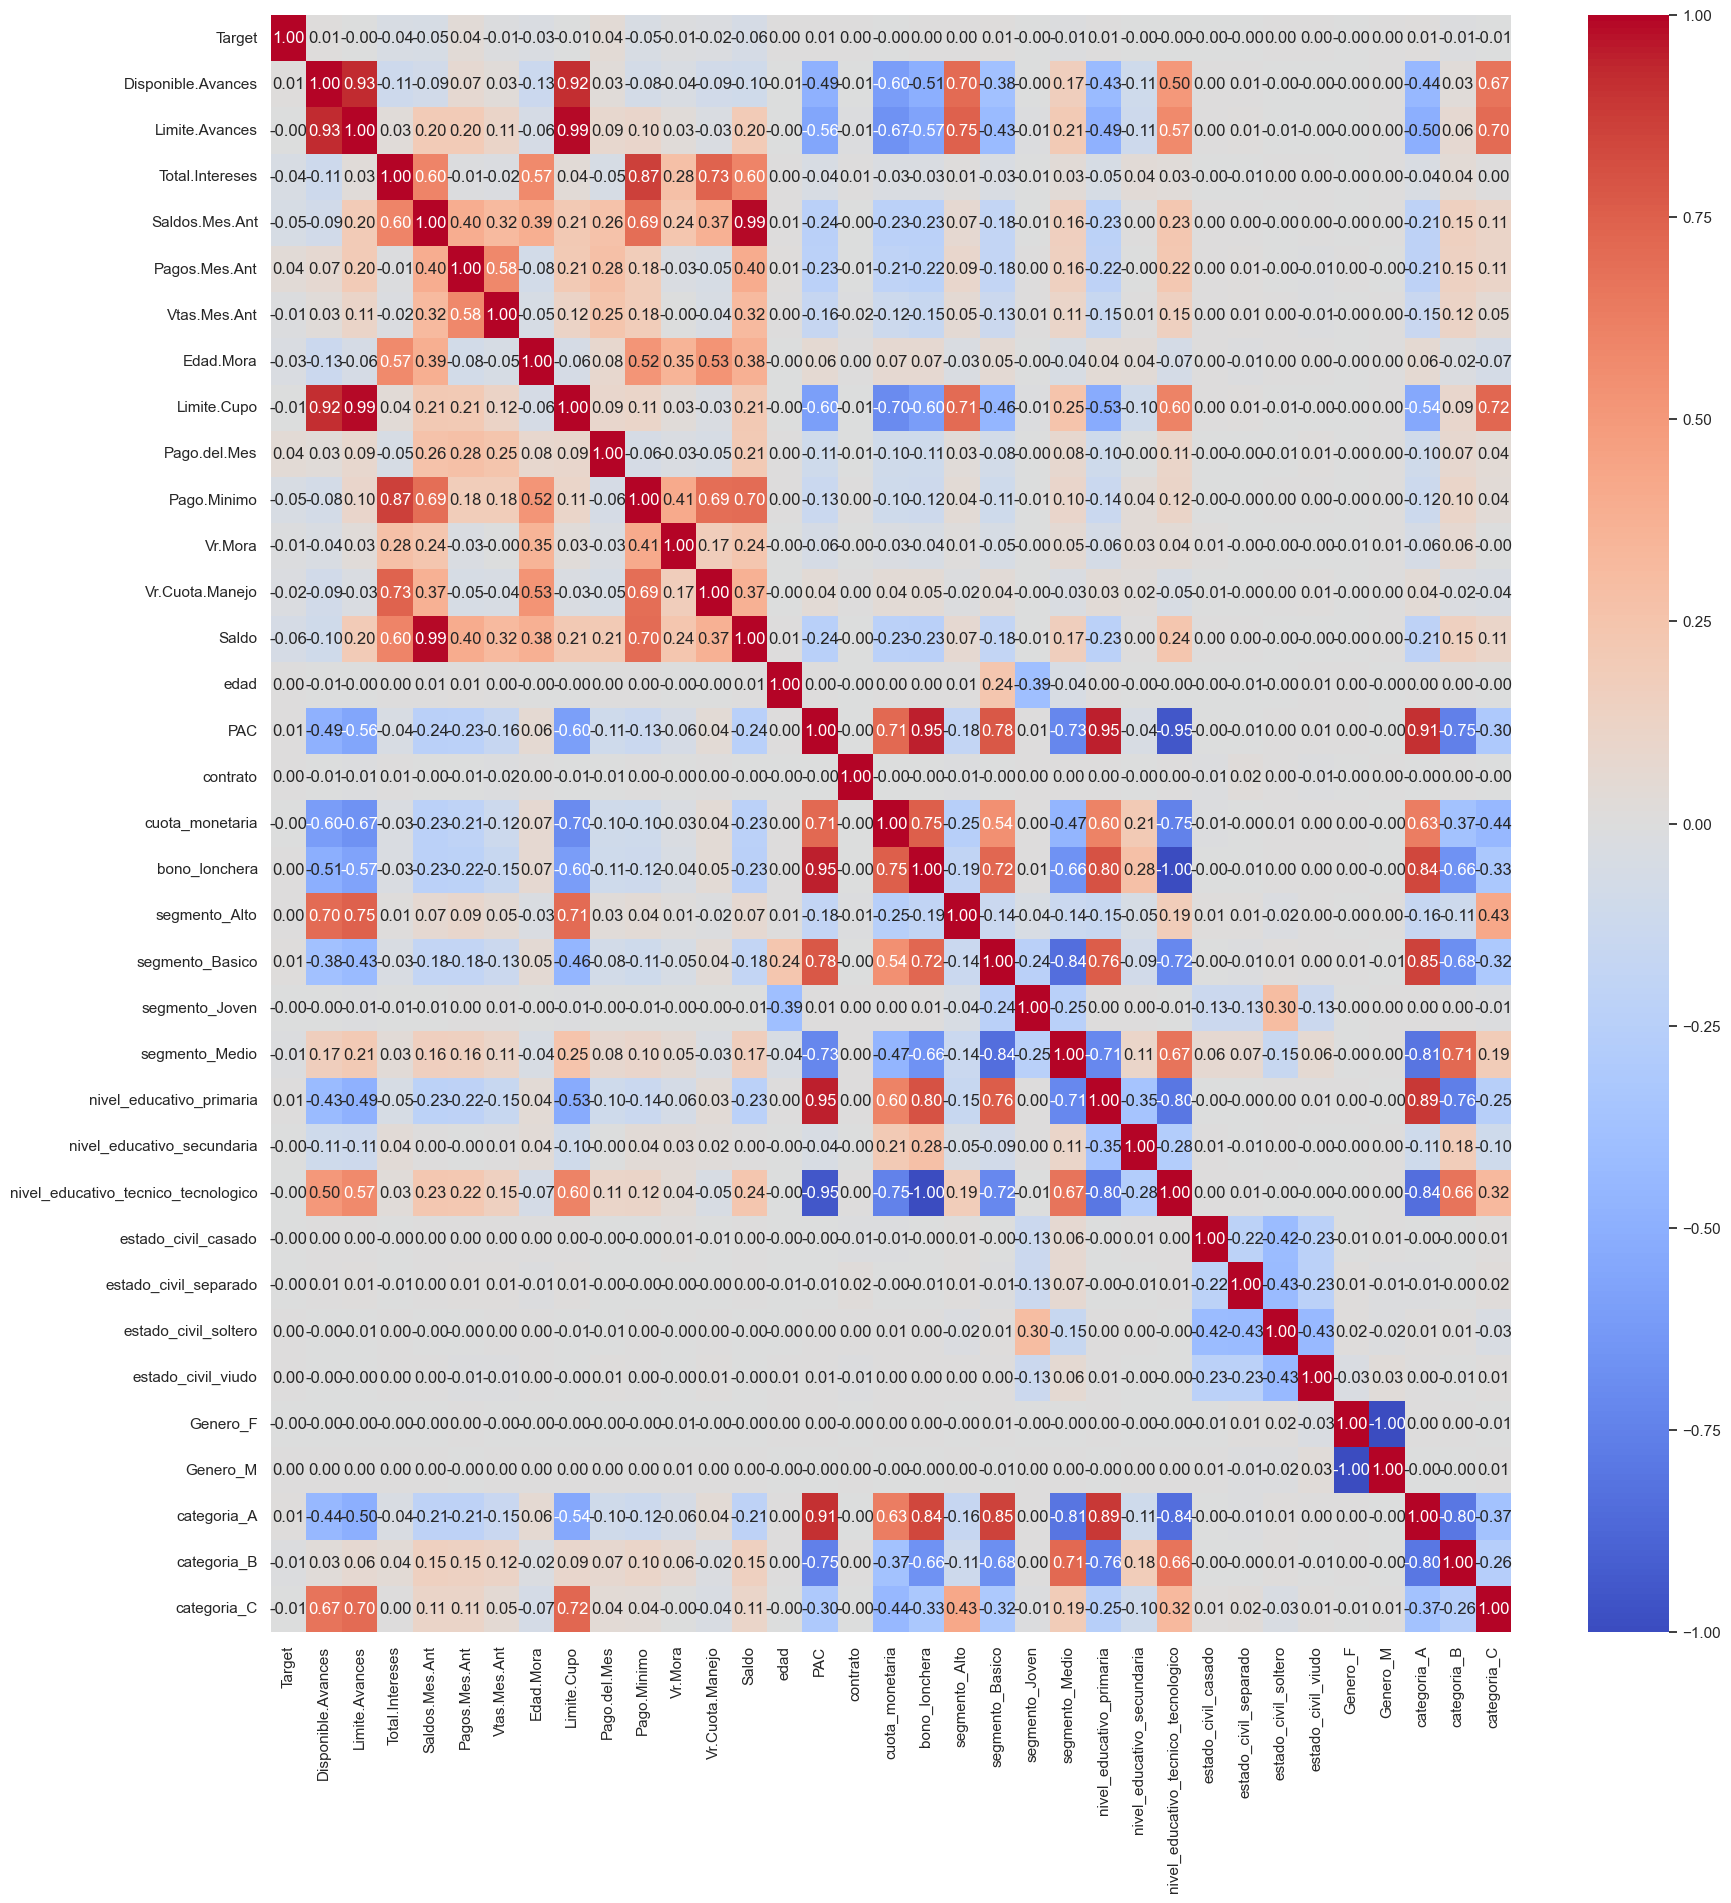

In [278]:
coef=df4.corr(method="pearson")
plt.figure(figsize=(20, 21))
sns.heatmap(coef, annot=True, cmap='coolwarm', fmt=".2f")

%md
## Aplicaremos la Variance Inflation Factor (VIF), para ver si existe multicolinealidad de las variables con respecto a mi target

%md

Regla de oro

VIF = 1: no hay colinealidad.

1 < VIF < 5: colinealidad moderada.

VIF > 5 (algunos usan > 10): colinealidad crítica.

In [279]:
# 1) Elige tus variables predictoras (todas menos la etiqueta)
X = df4.drop(columns=["Target"])

# 2) (Opcional) Asegúrate de no tener NaN en X
X = X.dropna()

# 3) Crea el DataFrame con los VIF
vif_data = pd.DataFrame({
    "variable": X.columns,
    "VIF": [
        variance_inflation_factor(X.values, i)
        for i in range(X.shape[1])
    ]
})

# 4) Ordena de mayor a menor para identificar rápidamente los problemas
vif_data = vif_data.sort_values("VIF", ascending=False).reset_index(drop=True)

print(vif_data)

                               variable        VIF
0                         bono_lonchera        inf
1                                   PAC        inf
2                           categoria_B        inf
3                           categoria_C        inf
4                           categoria_A        inf
5                              Genero_M        inf
6                              Genero_F        inf
7                    estado_civil_viudo        inf
8                  estado_civil_soltero        inf
9                 estado_civil_separado        inf
10                  estado_civil_casado        inf
11  nivel_educativo_tecnico_tecnologico        inf
12           nivel_educativo_secundaria        inf
13             nivel_educativo_primaria        inf
14                       segmento_Medio        inf
15                       segmento_Joven        inf
16                      segmento_Basico        inf
17                        segmento_Alto        inf
18                       Limite

In [281]:
df4.drop(columns=['categoria_A','nivel_educativo_primaria','nivel_educativo_tecnico_tecnologico','segmento_Basico','bono_lonchera','Saldos.Mes.Ant','Pago.Minimo','Vr.Cuota.Manejo',
'Limite.Cupo','Genero_F','estado_civil_viudo','estado_civil_separado','Limite.Avances','segmento_Joven','categoria_B'], inplace=True)

In [282]:
# 1) Elige tus variables predictoras (todas menos la etiqueta)
X = df4.drop(columns=["Target"])

# 2) (Opcional) Asegúrate de no tener NaN en X
X = X.dropna()

# 3) Crea el DataFrame con los VIF
vif_data = pd.DataFrame({
    "variable": X.columns,
    "VIF": [
        variance_inflation_factor(X.values, i)
        for i in range(X.shape[1])
    ]
})

# 4) Ordena de mayor a menor para identificar rápidamente los problemas
vif_data = vif_data.sort_values("VIF", ascending=False).reset_index(drop=True)

print(vif_data)

                      variable        VIF
0                          PAC  14.502965
1              cuota_monetaria  11.087336
2                         edad   8.250801
3           Disponible.Avances   6.095407
4                     contrato   5.540781
5                        Saldo   3.474156
6               segmento_Medio   3.074683
7                segmento_Alto   2.795255
8              Total.Intereses   2.430573
9                  categoria_C   2.219449
10        estado_civil_soltero   2.124068
11               Pagos.Mes.Ant   2.011865
12                    Genero_M   1.978736
13                   Edad.Mora   1.885147
14                Vtas.Mes.Ant   1.652517
15         estado_civil_casado   1.466247
16  nivel_educativo_secundaria   1.284201
17                Pago.del.Mes   1.234735
18                     Vr.Mora   1.201299


<Axes: >

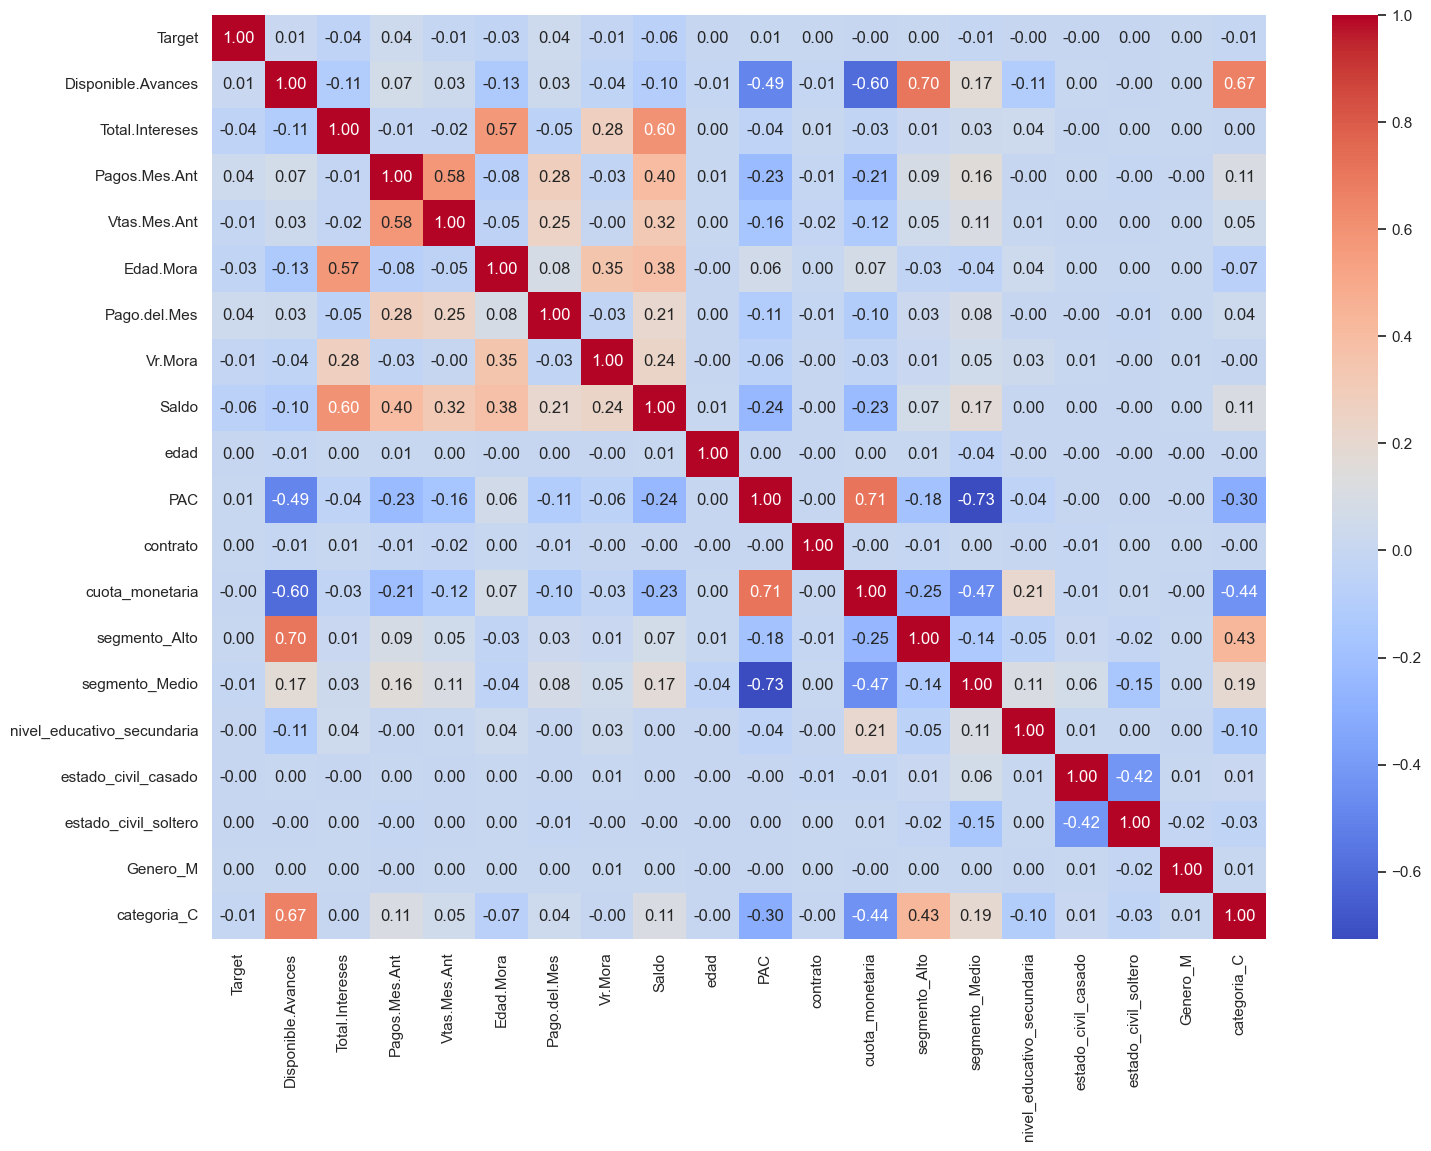

In [283]:
coef=df4.corr(method="pearson")
plt.figure(figsize=(17, 12))
sns.heatmap(coef, annot=True, cmap='coolwarm', fmt=".2f")

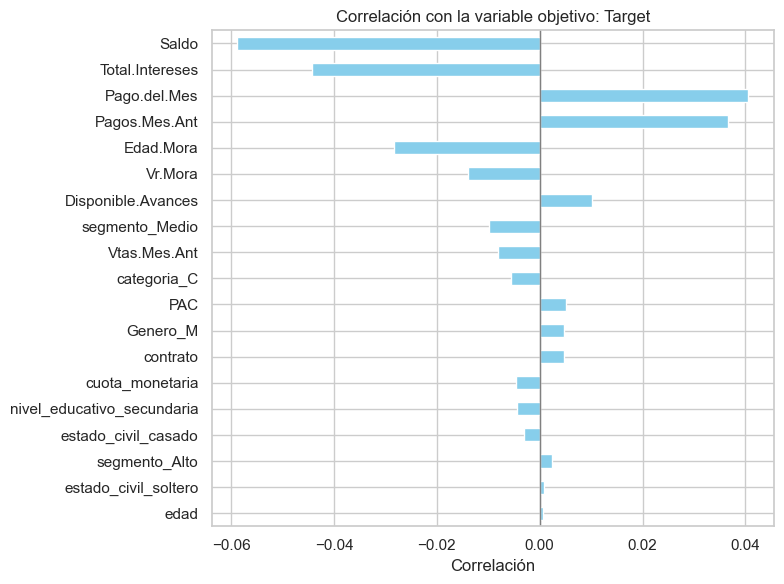

In [284]:
correlacion_objetivo(df4, variable_objetivo="Target", top_n=33)

In [285]:
df4.isnull().sum().sort_values(ascending=False)/len(df4)

Target                        0.0
Disponible.Avances            0.0
Total.Intereses               0.0
Pagos.Mes.Ant                 0.0
Vtas.Mes.Ant                  0.0
Edad.Mora                     0.0
Pago.del.Mes                  0.0
Vr.Mora                       0.0
Saldo                         0.0
edad                          0.0
PAC                           0.0
contrato                      0.0
cuota_monetaria               0.0
segmento_Alto                 0.0
segmento_Medio                0.0
nivel_educativo_secundaria    0.0
estado_civil_casado           0.0
estado_civil_soltero          0.0
Genero_M                      0.0
categoria_C                   0.0
dtype: float64

In [286]:
df4.to_parquet(r'C:\Users\Admin\Downloads\Colsubsidio\plata\preprocesada.parquet')

In [287]:
import subprocess

with open('requirements.txt', 'w') as f:
    subprocess.run(['pip', 'freeze'], stdout=f)
